In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import ahrs
import consts
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from datetime import datetime

In [41]:
"""
Generate synthetic data for UKF
"""

from typing import Tuple
from quat import prop_matrix
from sensors import acc_read
import numpy as np
from consts import N, dt, sig_gy_w, sig_gy_b, sig_acc
import scipy
from scipy.integrate import cumulative_trapezoid

def gen_data(gt_omega=None) -> Tuple:
    """
    Returns noisy gyro and accel, as well as GT attitude
    """
    if gt_omega is None:
        # Generate gt angular velocity
        gt_omega = np.zeros((N, 3, 1))
        num_acc_steps = 5
        for i in range(3):
            acc_fn = scipy.interpolate.interp1d(
                np.arange(num_acc_steps + 1),
                np.random.randn(num_acc_steps + 1) * dt / 50,
                kind="cubic",
            )
            gt_omega[:, i, 0] = cumulative_trapezoid(
                acc_fn(np.linspace(0, num_acc_steps, N)), dx=dt, initial=0, axis=0
            )
    
    # Make omega zero for the last chunk of time
    stationary_time = int(N * 0.33)
    gt_omega[-stationary_time: ] = 0
    # gt_omega[:stationary_time] = 0
    
    # Generate gt attitude
    gt_q = np.zeros((N, 4, 1))
    gt_q[0,3] = 1
    for i in range(1, N):
        gt_q[i] = prop_matrix(gt_omega[i]) @ gt_q[i - 1]
        # normalize
        gt_q[i] /= np.linalg.norm(gt_q[i])

    gt_bias_drift = np.random.randn(N, 3, 1) * sig_gy_b
    gt_bias = cumulative_trapezoid(gt_bias_drift, dx=dt, initial=0, axis=0)
    # gt_bias += np.random.randn(3, 1) * sig_gy_b * 10 # Jump start the bias
    # gt_bias = np.zeros((N, 3, 1))

    noisy_omega = gt_omega + gt_bias + np.random.randn(N, 3, 1) * sig_gy_w
    noisy_acc = np.zeros((N, 3, 1))
    for i in range(N):
        noisy_acc[i] = acc_read(gt_q[i]) + np.random.randn(3, 1) * sig_acc

    return gt_q, gt_omega, gt_bias, noisy_omega, noisy_acc
# gt_q, gt_omega, gt_bias, noisy_omega, noisy_acc = gen_data()
# t = np.arange(gt_q.shape[0]) * consts.dt


In [43]:
def gen_save_data(name):
    gt_q, gt_omega, gt_bias, noisy_omega, noisy_acc = gen_data()
    sig_gy_b = consts.sig_gy_b
    sig_gy_w = consts.sig_gy_w
    sig_acc = consts.sig_acc
    dt = consts.dt

    np.savez_compressed(f"data/{name}.npz", gt_q=gt_q, gt_omega=gt_omega, gt_bias=gt_bias, noisy_omega=noisy_omega, noisy_acc=noisy_acc, sig_gy_b=sig_gy_b, sig_gy_w=sig_gy_w, sig_acc=sig_acc, dt=dt)
# gen_save_data(grade)

In [61]:
grade = consts.imu_grade
def load_data(path):
    data = np.load(path)
    gt_q = data["gt_q"]
    gt_omega = data["gt_omega"]
    gt_bias = data["gt_bias"]
    noisy_omega = data["noisy_omega"]
    noisy_acc = data["noisy_acc"]
    t = np.arange(gt_q.shape[0]) * data["dt"]
    return t, gt_q, gt_omega, gt_bias, noisy_omega, noisy_acc

t, gt_q, gt_omega, gt_bias, noisy_omega, noisy_acc = load_data(f"data/{grade.lower()}.npz")


In [62]:
np.savetxt(f"outputs/{grade.lower()}_gt_omega.csv", gt_omega[:, :, 0], delimiter=",")
np.savetxt(f"outputs/{grade.lower()}_gt_bias.csv", gt_bias[:, :, 0], delimiter=",")
np.savetxt(f"outputs/{grade.lower()}_noisy_omega.csv", noisy_omega[:, :, 0], delimiter=",")
np.savetxt(f"outputs/{grade.lower()}_noisy_acc.csv", noisy_acc[:, :, 0], delimiter=",")


In [63]:
def save_traj(q, path):
    if len(q.shape) == 3:
        q = q[:, :, 0]
    N, d = q.shape
    assert d == 4
    # Assume q is xyzw, need to save as wxyz
    q_wxyz = q[:, (3, 0, 1, 2)]
    np.savetxt(path, q_wxyz, delimiter=",")
    
def get_fname(method, grade, q0_str):
    return f"outputs/{method}_{grade}_{q0_str}.csv"

In [64]:
from quat import prop_matrix
from usque import run_ukf, DEFAULT_TYPE
from consts import n, N

def run_trial(grade):
    grade_str = grade.lower()
    t, gt_q, gt_omega, gt_bias, noisy_omega, noisy_acc = load_data(f"data/{grade_str}.npz")
    save_traj(gt_q[:, :, 0], f"outputs/gt_{grade_str}.csv")
    Y = noisy_acc  # IMU Accel observations
    W = noisy_omega  # IMU Gyro observations

    for i, q0 in enumerate((np.array([[0, 0, 0, 1]]).T, 0.5 * np.array([[0, np.sqrt(2), np.sqrt(2), 0]]).T)):
        q0_wxyz = q0[(3, 0, 1, 2), :]
        
        if i == 0:
            q0_str = "correct_init"
        else:
            q0_str = "incorrect_init"
        
        # Naive
        naive_q = np.zeros((N, 4, 1))
        naive_q[0, :, 0] = q0[:, 0]
        for i in range(1, N):
            naive_q[i] = prop_matrix(W[i]) @ naive_q[i - 1]
            # normalize
            naive_q[i] /= np.linalg.norm(naive_q[i])

        save_traj(naive_q, get_fname("naive", grade_str, q0_str))
            
        # UKF
        x0 = np.array([[0, 0, 0, 0, 0, 0]], dtype=DEFAULT_TYPE).T
        
        P0 = np.eye(6)
        if i == 0:
            P0[:3, :3] *= 1e-3
        else: 
            P0[:3, :3] *= 1e1

        P0[3:, 3:] *= 1e-3
        
        ukf_q, P = run_ukf(x0, P0, W, Y, q0)
        save_traj(ukf_q, get_fname("ukf", grade_str, q0_str))
        
        # EKF
        ekf = ahrs.filters.ekf.EKF(gyr=W[:, :, 0], acc=-Y[:, :, 0], frequency=consts.fs, q0=q0_wxyz[:, 0], var_acc=consts.sig_acc**2, var_gyr=consts.sig_gy_w**2)
        ekf_q = ekf.Q # wxyz
        ekf_q = ekf_q[:, (1, 2, 3, 0)]

        save_traj(ekf_q, get_fname("ekf", grade_str, q0_str))

        # Comp
        comp_filt = ahrs.filters.complementary.Complementary(gyr=W[:, :, 0], acc=Y[:, :, 0], frequency=consts.fs, gain=0.1, q0=q0_wxyz[:, 0])
        q_cf = comp_filt.Q
        comp_q = q_cf[:, (1, 2, 3, 0)]

        save_traj(comp_q, get_fname("comp", grade_str, q0_str))

        # Madg
        madg = ahrs.filters.madgwick.Madgwick(gyr=W[:, :, 0], acc=Y[:, :, 0], frequency=consts.fs, q0=q0_wxyz[:, 0])
        madg_q = madg.Q
        madg_q = madg_q[:, (1, 2, 3, 0)]
        
        save_traj(madg_q, get_fname("madg", grade_str, q0_str))


In [65]:
run_trial(consts.imu_grade)

100%|██████████████████████████████████████████████████████████████| 11999/11999 [00:28<00:00, 414.58it/s]


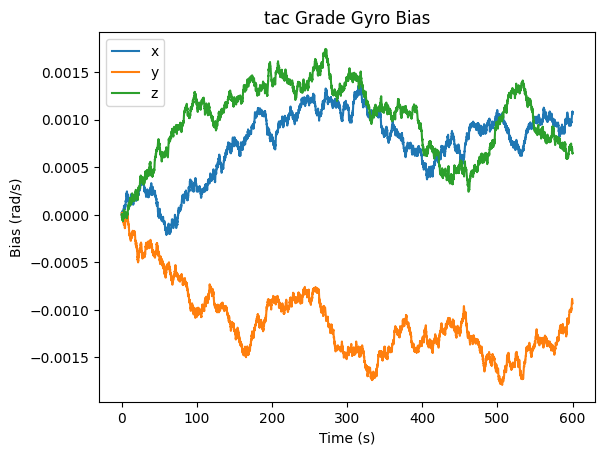

In [66]:
plt.plot(t, gt_bias[:, :, 0])
plt.xlabel('Time (s)')
plt.ylabel("Bias (rad/s)")
plt.legend(['x', 'y', 'z'])

plt.title(f'{grade} Grade Gyro Bias')
plt.savefig(f'figs/{grade}_gt_bias.png')

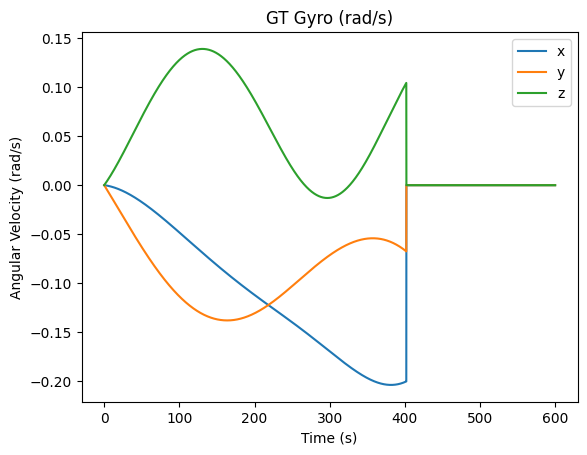

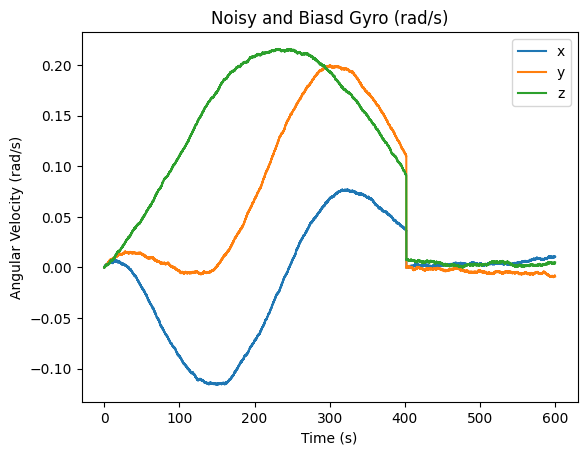

In [46]:
plt.plot(t, gt_omega[:, :, 0])
plt.xlabel('Time (s)')
plt.ylabel("Angular Velocity (rad/s)")
plt.legend(['x', 'y', 'z'])
plt.title('GT Gyro (rad/s)')
plt.savefig(f'figs/{grade}_gt_omega.png')
plt.show()
plt.plot(t, noisy_omega[:, :, 0])
plt.xlabel('Time (s)')
plt.ylabel("Angular Velocity (rad/s)")
plt.legend(['x', 'y', 'z'])
plt.title('Noisy and Biasd Gyro (rad/s)')
plt.savefig(f'figs/{grade}_noisy_omega.png')

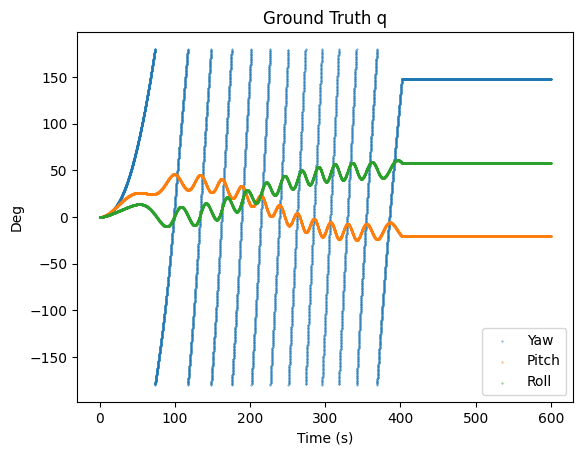

In [47]:
from quat import q_mul, q_inv
def plot_q(q: np.ndarray, title: str = None) -> None:
    assert q.shape[1] == 4
    if len(q.shape) == 3:
        q = q[:, :, 0]
    rot = R.from_quat(q)
    ypr = rot.as_euler("ZYX", degrees=True)
    plt.scatter(t, ypr[:, 0], s=0.1, label="Yaw")
    plt.scatter(t, ypr[:, 1], s=0.1, label="Pitch")
    plt.scatter(t, ypr[:, 2], s=0.1, label="Roll")
    if title is not None:
        plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Deg")
    plt.legend()
    plt.show()

def get_err(q_est, q_gt):
    assert q_est.shape == q_gt.shape
    N, _, _ = q_est.shape
    
    rpy_est = R.from_quat(q_est[:, :, 0]).as_euler("ZYX", degrees=True)
    rpy_gt = R.from_quat(q_gt[:, :, 0]).as_euler("ZYX", degrees=True)
    
    rot_errs = rpy_est - rpy_gt
    rot_errs = (rot_errs + 360) % 360  # Make all positive
    rot_errs[rot_errs > 180] -= 360 # 2 pi wrap errors
    
    plt.scatter(t, rot_errs[:, 0], s=0.1)
    plt.scatter(t, rot_errs[:, 1], s=0.1)
    plt.scatter(t, rot_errs[:, 2], s=0.1)
    # plt.ylim([-3, 3])
    plt.legend(["yaw", "Pitch", "Roll"])
    plt.show()

    return rot_errs.copy()


plot_q(gt_q, title="Ground Truth q")

In [48]:
from usque import run_ukf, DEFAULT_TYPE
from consts import n, N

# Initialize everything
x0 = np.array([[0, 0, 0, 0, 0, 0]], dtype=DEFAULT_TYPE).T
# P0 = diag([attitude err cov, bias err cov])
P0 = np.eye(6)
P0[:3, :3] *= 1e-3
P0[3:, 3:] *= 1e-1

Y = noisy_acc  # IMU Accel observations
W = noisy_omega  # IMU Gyro observations

# q0 = np.array([[0, 0.7071, 0.7071, 0]]).T
q0 = np.array([[0, 0, 0, 1]]).T
ukf_q, P = run_ukf(x0, P0, W, Y, q0)

100%|██████████████████████████████████████████████████████████████| 11999/11999 [00:27<00:00, 428.57it/s]


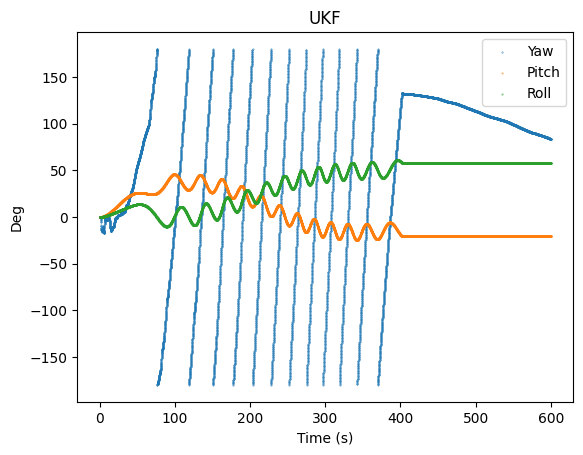

In [49]:
plot_q(ukf_q, title="UKF")


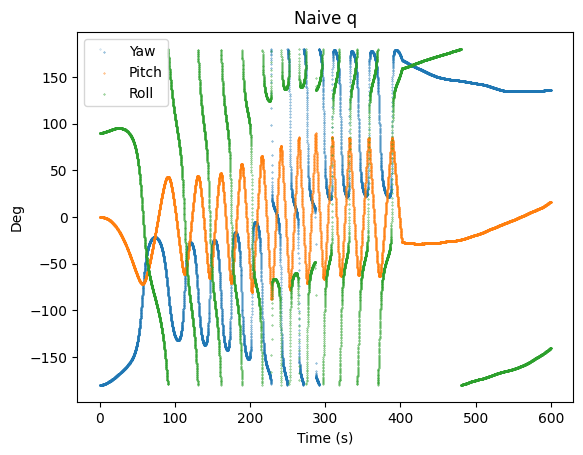

In [56]:
from quat import prop_matrix

naive_q = np.zeros((N, 4, 1))
naive_q[0, :, 0] = np.array([0, 0.707, 0.707, 0])
for i in range(1, N):
    naive_q[i] = prop_matrix(W[i]) @ naive_q[i - 1]
    # normalize
    naive_q[i] /= np.linalg.norm(naive_q[i])
    
plot_q(naive_q, title="Naive q")

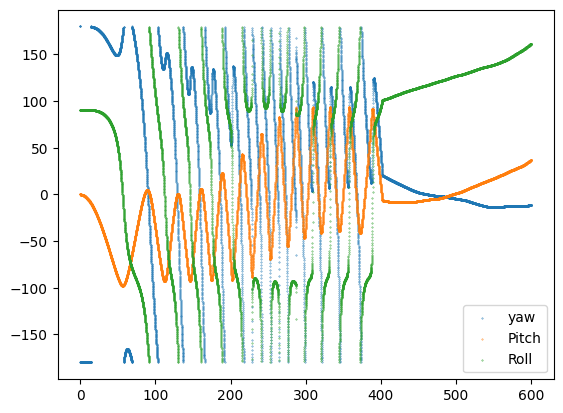

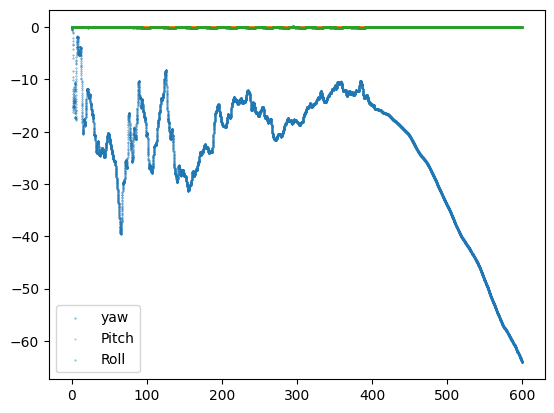

8.67465290253824

In [59]:

errs = get_err(naive_q, gt_q)
errs2 = get_err(ukf_q, gt_q)
np.linalg.norm(errs2[10:, 1:])

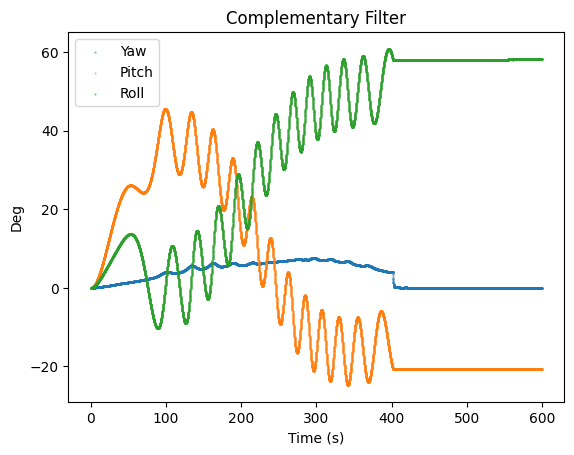

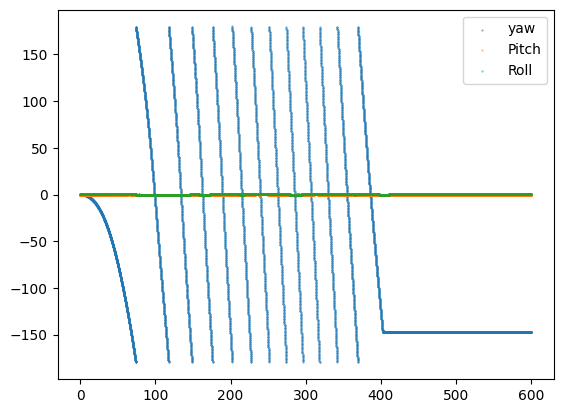

0.14592669654581078

In [60]:
import ahrs
# NOTE: ahrs uses WXYZ quaternions

comp_filt = ahrs.filters.complementary.Complementary(gyr=W[:, :, 0], acc=Y[:, :, 0], frequency=consts.fs, gain=0.1)
q_cf = comp_filt.Q
q_cf_shift = np.hstack((q_cf[:, 1:], q_cf[:, 0:1]))

plot_q(q_cf_shift, title="Complementary Filter")
errs3 = get_err(q_cf_shift[:, :, np.newaxis], gt_q)
np.mean(np.linalg.norm(errs3[10:, 1:], axis=1))

In [53]:
# ar = ahrs.filters.angular.AngularRate(gyr=W[:, :, 0], q0=np.array([0.707, 0.707, 0, 0]), method="series", frequency=consts.fs)
# gy_int = ar.Q
# print(gy_int[0])
# gy_int = np.hstack((gy_int[:, 1:], gy_int[:, 0:1]))
# plot_q(gy_int)
# errs3 = get_err(gy_int[:, :, np.newaxis], gt_q)

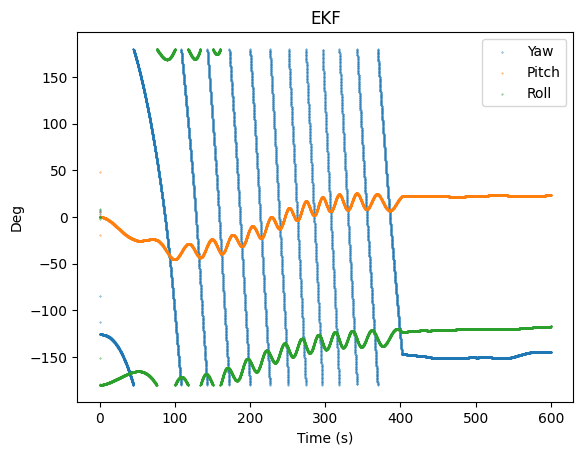

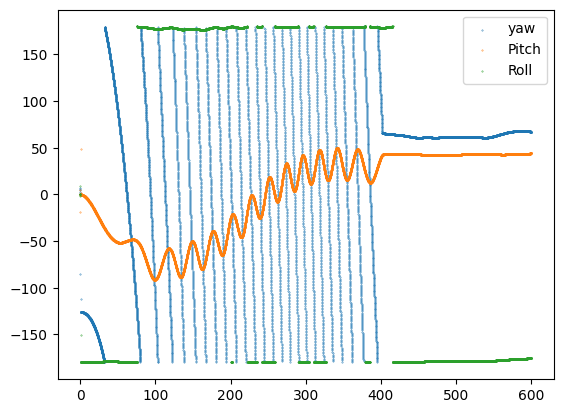

98.14018279196826

In [54]:
import ahrs
# NOTE: ahrs uses WXYZ quaternions
Y = noisy_acc  # IMU Accel observations
W = noisy_omega  # IMU Gyro observations

ekf = ahrs.filters.ekf.EKF(gyr=W[:, :, 0], acc=Y[:, :, 0], frequency=consts.fs, var_acc=consts.sig_acc**2, var_gyr=consts.sig_gy_w**2)
ekf_q = ekf.Q
ekf_q = np.hstack((ekf_q[:, 1:], ekf_q[:, 0:1]))

plot_q(ekf_q, title="EKF")
errs3 = get_err(ekf_q[:, :, np.newaxis], gt_q)
np.mean(np.linalg.norm(errs3[10:, :2], axis=1))

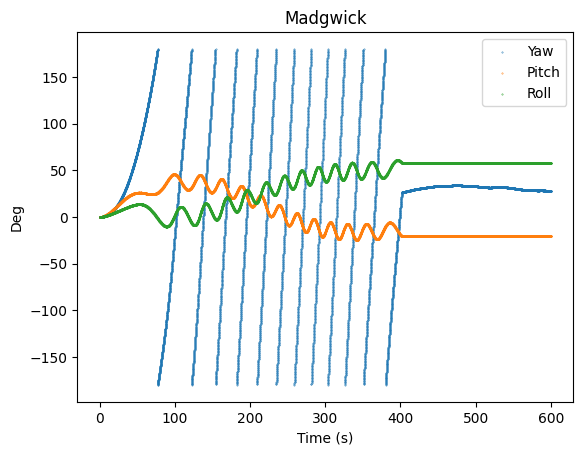

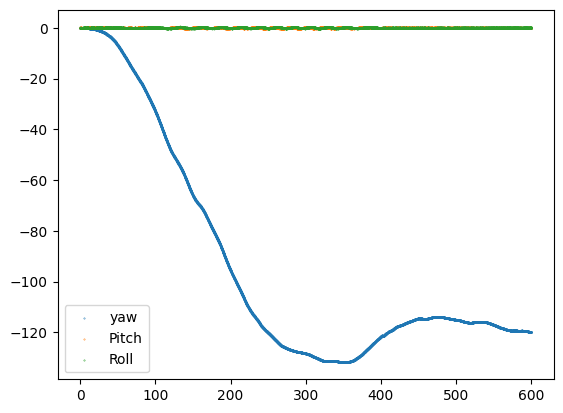

11183.65495226846

In [55]:
import ahrs
# NOTE: ahrs uses WXYZ quaternions

madg = ahrs.filters.madgwick.Madgwick(gyr=W[:, :, 0], acc=Y[:, :, 0], frequency=consts.fs) #, q0=np.array([0, 0.707, 0.707, 0]))
madg_q = madg.Q
madg_q = np.hstack((madg_q[:, 1:], madg_q[:, 0:1]))

plot_q(madg_q, title="Madgwick")
errs5 = get_err(madg_q[:, :, np.newaxis], gt_q)
np.linalg.norm(errs5[10:, :2])